In [1]:
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import gc
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("./stacking1.csv", index_col=0)
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

In [3]:
df.head()

SK_ID_CURR       LGB       XGB       CGB  TARGET        ET        RF
0      100002  0.157865  0.238615  0.432211     1.0  0.344763  0.228391
1      100003  0.019035  0.040432  0.097911     0.0  0.040799  0.042614
2      100004  0.016370  0.033769  0.091090     0.0  0.034295  0.052903
3      100006  0.032157  0.027048  0.112783     0.0  0.041558  0.047960
4      100007  0.064381  0.088442  0.278452     0.0  0.072826  0.073878

In [5]:
def gen_features(df):
    columns = ['LGB', 'XGB', 'CGB', 'ET', 'RF']
    df['var'] = np.var(df[columns], axis=1)
    df['sum'] = np.sum(df[columns], axis=1)
    df['max'] = np.max(df[columns], axis=1)
    df['min'] = np.min(df[columns], axis=1)
    
    weighted = [0.5, 0.1, 0.1, 0.2,0.1]
    np.multiply(df[columns], weighted)
    df['var_weighted'] = np.var(np.multiply(df[columns], weighted), axis=1)
    df['sum_weighted'] = np.sum(np.multiply(df[columns], weighted), axis=1)

    for i in columns:
        df[i+'_square'] = np.square(df[i])
        df[i+'_sqrt'] = np.sqrt(df[i])
        df[i+'_ln'] = np.log(df[i])
        
    for i in columns:
        for j in columns:
            if i != j:
                df[i+'*'+j]=df[i]*df[j]
                df[i+'/'+j]=df[i]/df[j]
    return df

In [6]:
df = gen_features(df)
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

In [11]:
def kfold_lightgbm(learning_rate, num_leaves, max_depth, min_split_gain, min_child_weight):
    global train_df
    num_folds = 5
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    oof_preds = np.zeros(train_df.shape[0])
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            bagging_fraction=0.9,
            bagging_freq = 5,
            learning_rate=learning_rate,
            num_leaves=int(num_leaves),
            colsample_bytree= 0.95,
            subsample= 0.9,
            max_depth=int(max_depth),
            
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=min_split_gain,
            
            min_child_weight=int(min_child_weight),
            )

        clf.fit(train_x, train_y, eval_set=[ (valid_x, valid_y)], 
                eval_metric= 'auc', verbose= 0, early_stopping_rounds= 100)
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]

    return roc_auc_score(train_df['TARGET'], oof_preds)

In [14]:
bo = BayesianOptimization(kfold_lightgbm, {'learning_rate': (0.05, 0.5), 
                                           'num_leaves': (30, 50), 
                                           'max_depth': (5, 10), 
                                           'min_split_gain': (0.01, 0.1), 
                                           'min_child_weight': (20, 50)}
                         )

gp_param={'kernel':None, 'alpha':1e-5}
bo.maximize()

Initialization
--------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   max_depth |   min_child_weight |   min_split_gain |   num_leaves | 
    1 | 00m42s |    0.78620 |          0.1172 |      9.8470 |            33.6840 |           0.0643 |      33.7195 | 
    2 | 00m40s |    0.76382 |          0.3316 |      9.8888 |            32.0419 |           0.0906 |      43.7691 | 
    3 | 00m35s |    0.75513 |          0.2654 |      7.5768 |            28.0938 |           0.0303 |      39.9481 | 
    4 | 00m38s |    0.77402 |          0.2555 |      8.6970 |            20.7887 |           0.0976 |      46.8630 | 
    5 | 00m45s |    0.77564 |          0.1071 |      9.2640 |            35.8881 |           0.0687 |      40.7211 | 
Bayesian Optimization
--------------------------------------------------------------------------------------------------------------------
 Step |   Time |     

/home/ray/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.36953379e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   10 | 00m45s |    0.77716 |          0.4994 |      9.8568 |            49.9098 |           0.0852 |      39.7443 | 
   11 | 00m44s |    0.79650 |          0.0859 |      5.0362 |            45.7100 |           0.0533 |      49.8111 | 
   12 | 00m44s |    0.74321 |          0.3762 |      9.8122 |            40.8408 |           0.0762 |      30.0476 | 
   13 | 01m01s |    0.75631 |          0.0500 |     10.0000 |            20.0000 |           0.0100 |      38.6240 | 
   14 | 00m49s |    0.74083 |          0.0500 |      5.0000 |            20.0000 |           0.0621 |      50.0000 | 


/home/ray/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.21475973e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   15 | 00m52s |    0.74047 |          0.0500 |      5.0000 |            50.0000 |           0.0100 |      44.6067 | 
   16 | 00m58s |    0.78173 |          0.0500 |      5.0000 |            26.9720 |           0.1000 |      30.0000 | 
   17 | 01m17s |    0.76186 |          0.0500 |     10.0000 |            40.1233 |           0.0100 |      50.0000 | 
   18 | 01m04s |    0.74370 |          0.0500 |     10.0000 |            20.0000 |           0.0100 |      50.0000 | 
   19 | 00m36s |    0.75432 |          0.5000 |      5.0000 |            20.0000 |           0.1000 |      30.0000 | 
   20 | 00m36s |    0.77985 |          0.5000 |      5.0000 |            34.6379 |           0.1000 |      50.0000 | 
   21 | 00m41s |    0.77264 |          0.5000 |     10.0000 |            27.3837 |           0.1000 |      30.0000 | 
   22 | 00m35s |    0.74963 |          0.5000 |      5.0019 |            35.8808 |           0.1000 |      34.5605 | 
   23 | 00m57s |    0.76809 |          0.0657 |      6.4

/home/ray/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([5.75476167e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ray/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.46125582e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


In [17]:
def kfold_lightgbm2(bagging_fraction, bagging_freq, colsample_bytree, subsample, reg_alpha, reg_lambda):
    global train_df
    num_folds = 5
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    oof_preds = np.zeros(train_df.shape[0])
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            bagging_fraction=bagging_fraction,
            bagging_freq = int(bagging_freq),
            learning_rate=0.0859,
            num_leaves=50,
            colsample_bytree= colsample_bytree,
            subsample= subsample,
            max_depth=5,
            
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            min_split_gain=0.0533,
            
            min_child_weight=46,
            )

        clf.fit(train_x, train_y, eval_set=[ (valid_x, valid_y)], 
                eval_metric= 'auc', verbose= 0, early_stopping_rounds= 100)
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]

    return roc_auc_score(train_df['TARGET'], oof_preds)

In [18]:
bo2 = BayesianOptimization(kfold_lightgbm2, {
                                            'bagging_fraction' : (0.5, 1), 
                                           'bagging_freq': (1, 5), 
                                           'colsample_bytree': (0.5, 1), 
                                           'subsample':(0.5, 1), 
                                           'reg_alpha': (0.01, 0.5), 
                                           'reg_lambda':(0.01, 0.5)}
                         )

gp_param={'kernel':None, 'alpha':1e-5}
bo2.maximize(**gp_param)

Initialization
-----------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   bagging_freq |   colsample_bytree |   reg_alpha |   reg_lambda |   subsample | 
    1 | 00m44s |    0.71905 |             0.8645 |         1.9910 |             0.6717 |      0.0427 |       0.0997 |      0.8540 | 
    2 | 00m36s |    0.74896 |             0.5681 |         4.3647 |             0.8740 |      0.4074 |       0.1321 |      0.5668 | 
    3 | 00m39s |    0.75548 |             0.5098 |         1.6857 |             0.8704 |      0.4048 |       0.0116 |      0.7454 | 
    4 | 00m45s |    0.77566 |             0.8436 |         4.5147 |             0.5764 |      0.4234 |       0.1358 |      0.6378 | 
    5 | 00m45s |    0.70779 |             0.9780 |         3.5547 |             0.6163 |      0.4953 |       0.0667 |      0.7574 | 
Bayesian Optimization
---------------------------------

In [19]:
def kfold_lightgbm(learning_rate, num_leaves, max_depth, min_split_gain, min_child_weight, 
                   bagging_fraction, bagging_freq, colsample_bytree, subsample, reg_alpha, reg_lambda):
    global train_df
    num_folds = 5
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    oof_preds = np.zeros(train_df.shape[0])
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            bagging_fraction=bagging_fraction,
            bagging_freq = int(bagging_freq),
            learning_rate=learning_rate,
            num_leaves=int(num_leaves),
            colsample_bytree= colsample_bytree,
            subsample= subsample,
            max_depth=int(max_depth),
            
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            min_split_gain=min_split_gain,
            
            min_child_weight=int(min_child_weight),
            )

        clf.fit(train_x, train_y, eval_set=[ (valid_x, valid_y)], 
                eval_metric= 'auc', verbose= 0, early_stopping_rounds= 100)
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]

    return roc_auc_score(train_df['TARGET'], oof_preds)

In [20]:
bo3 = BayesianOptimization(kfold_lightgbm, {'learning_rate': (0.05, 0.99), 
                                           'num_leaves': (30, 150), 
                                           'max_depth': (5, 15), 
                                           'min_split_gain': (0.01, 0.5), 
                                           'min_child_weight': (10, 100),
                                           'bagging_fraction' : (0.5, 1), 
                                           'bagging_freq': (1, 5), 
                                           'colsample_bytree': (0.5, 1), 
                                           'subsample':(0.5, 1), 
                                           'reg_alpha': (0.01, 0.5), 
                                           'reg_lambda':(0.01, 0.5)
                                          }
                         )

gp_param={'kernel':None, 'alpha':1e-5}
bo3.maximize(**gp_param)

Initialization
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   bagging_freq |   colsample_bytree |   learning_rate |   max_depth |   min_child_weight |   min_split_gain |   num_leaves |   reg_alpha |   reg_lambda |   subsample | 
    1 | 00m33s |    0.76052 |             0.5784 |         3.2964 |             0.7404 |          0.4362 |      7.9397 |            18.0189 |           0.2130 |     149.1668 |      0.0689 |       0.3799 |      0.8116 | 
    2 | 00m39s |    0.74643 |             0.6699 |         3.8447 |             0.7477 |          0.4248 |      9.9505 |            84.4191 |           0.3560 |     127.3670 |      0.0210 |       0.1570 |      0.8077 | 
    3 | 00m42s |    0.75887 |             0.8386 |         4.4702 |             0.9642 |          0.5264 |

In [28]:
def lr_bo(gamma, c):
    global train_df
    num_folds = 5
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    oof_preds = np.zeros(train_df.shape[0])
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        # LightGBM parameters found by Bayesian optimization
        clf = LogisticRegression(
            penalty='l1' if gamma >= 0.5 else 'l2',
            C=c
        )
        #clf = SVC(C=c, gamma=gamma)

        clf.fit(train_x, train_y)
        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]

    return roc_auc_score(train_df['TARGET'], oof_preds)

In [ ]:
bo = BayesianOptimization(lr_bo, {'c':(0.01,100), 'gamma':(0.01, 0.99)})

gp_param={ 'alpha':1e-5}
bo.maximize(**gp_param)

Initialization
-----------------------------------------------------
 Step |   Time |      Value |         c |     gamma | 
    1 | 01m10s |    0.79838 |   78.6308 |    0.2867 | 
    2 | 23m30s |    0.79840 |   59.2071 |    0.5007 | 
    3 | 01m33s |    0.79838 |   13.5072 |    0.4321 | 
    4 | 01m47s |    0.79838 |   79.5330 |    0.0678 | 
    5 | 01m36s |    0.79840 |   58.2799 |    0.3879 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         c |     gamma | 
    6 | 00m41s |    0.79846 |    0.0119 |    0.2360 | 
    7 | 17m54s |    0.79843 |   99.9976 |    0.9516 | 
    8 | 02m14s |    0.79833 |    0.0111 |    0.8930 | 
    9 | 19m08s |    0.79840 |   99.9955 |    0.9350 | 
   10 | 00m38s |    0.79846 |    0.0100 |    0.3034 | 
   11 | 01m50s |    0.79837 |  100.0000 |    0.0106 | 
   12 | 02m39s |    0.79833 |    0.0114 |    0.9094 | 
   13 | 01m34s |    0.79837 |   99.9968 |    0.3426 | 
   14 | 00m38s |    0.79846 | 

/home/ray/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


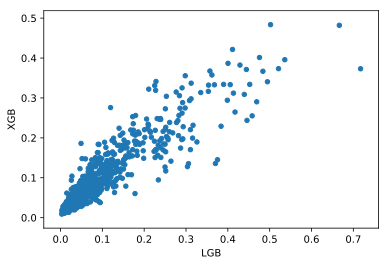

In [29]:
import seaborn as sns
temp = df.loc[:, ['LGB', 'XGB']].sample(1000)
temp.plot(kind='scatter', x='LGB', y='XGB')

In [13]:
df['rank_lgb'] =df.LGB.rank(method='min')
df['rank_cgb'] =df.CGB.rank(method='min')
df['rank_mean'] = (df['rank_lgb'] + df['rank_cgb']) / 2
weights = [0.7, 0.3]
df['Score'] = df.loc[:, ['rank_lgb', 'rank_cgb']].mul(weights).sum(1) / df.shape[0]


In [21]:
test_df['TARGET'] = df.loc[df.TARGET.isnull(), 'Score']
test_df[['SK_ID_CURR', 'TARGET']].to_csv("../../data/submission/for_weighted/lgb_xgb_weighted_rank.csv", index= False)

/home/ray/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
df.loc[df.TARGET.isnull(), 'Score'].shape

(48744,)

In [17]:
from imblearn.under_sampling import AllKNN, 

In [25]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
feats = ['LGB', 'CGB']
x_train = train_df[feats]
y_train = train_df['TARGET']

In [27]:
df.head()

SK_ID_CURR       LGB       XGB       CGB  TARGET        ET        RF  \
0      100002  0.157865  0.238615  0.432211     1.0  0.344763  0.228391   
1      100003  0.019035  0.040432  0.097911     0.0  0.040799  0.042614   
2      100004  0.016370  0.033769  0.091090     0.0  0.034295  0.052903   
3      100006  0.032157  0.027048  0.112783     0.0  0.041558  0.047960   
4      100007  0.064381  0.088442  0.278452     0.0  0.072826  0.073878   

        var       sum       max    ...        ET*RF     ET/RF    RF*LGB  \
0  0.009331  1.401845  0.432211    ...     0.078741  1.509529  0.036055   
1  0.000694  0.240792  0.097911    ...     0.001739  0.957404  0.000811   
2  0.000649  0.228427  0.091090    ...     0.001814  0.648258  0.000866   
3  0.000967  0.261505  0.112783    ...     0.001993  0.866525  0.001542   
4  0.006690  0.577979  0.278452    ...     0.005380  0.985762  0.004756   

     RF/LGB    RF*XGB    RF/XGB    RF*CGB    RF/CGB     RF*ET     RF/ET  
0  1.446748  0.054498  0.957156  0.098713  0.528426  0.078741  0.662458  
1  2.238742  0.001723  1.053970  0.004172  0.435235  0.001739  1.044491  
2  3.231594  0.001786  1.566595  0.004819  0.580769  0.001814  1.542595  
3  1.491430  0.001297  1.773129  0.005409  0.425238  0.001993  1.154035  
4  1.147512  0.006534  0.835331  0.020572  0.265318  0.005380  1.014444  

[5 rows x 68 columns]

In [20]:

x_train,y_train = AllKNN().fit_sample(x_train,y_train)

In [28]:
num_folds = 5
folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
oof_preds = np.zeros(train_df.shape[0])

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
    # LightGBM parameters found by Bayesian optimization
    clf = LogisticRegression(
        penalty= 'l2',
        C=0.01
    )

    clf.fit(train_x, train_y)
    oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]

print(roc_auc_score(train_df['TARGET'], oof_preds))

0.7967666596036911


In [31]:
test_df['TARGET'] = df.loc[df.TARGET.isnull(), 'LGB']
test_df[['SK_ID_CURR', 'TARGET']].to_csv("../../data/submission/for_weighted/submission_kernel01.csv", index= False)

/home/ray/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# 输出

In [ ]:
# 5 features best parameter
# Step |   Time |      Value |   bagging_fraction |   bagging_freq |   colsample_bytree |   learning_rate |   max_depth |   min_child_weight |   min_split_gain |   num_leaves |   reg_alpha |   reg_lambda |   subsample | 
# 24 | 02m53s |    0.79628 |             0.5000 |         5.0000 |             0.5000 |          0.9900 |     15.0000 |            82.0520 |           0.1235 |      30.0000 |      0.0100 |       0.0100 |      0.7433 | 


In [11]:
num_folds = 5
folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
oof_preds = np.zeros(train_df.shape[0])
oof_test = np.zeros(test_df.shape[0])
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
        nthread=4,
        n_estimators=10000,
        bagging_fraction=0.5,
        bagging_freq = 5,
        learning_rate=0.99,
        num_leaves=30,
        colsample_bytree= 0.5,
        subsample= 0.7433,
        max_depth=15,

        reg_alpha= 0.01,
        reg_lambda=0.01,
        min_split_gain=0.1235,

        min_child_weight=82,
        )

    clf.fit(train_x, train_y, eval_set=[ (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 0, early_stopping_rounds= 100)
    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    oof_test[:] += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / num_folds

print (roc_auc_score(train_df['TARGET'], oof_preds))

0.7958723052224559


In [12]:
test_df['TARGET'] = oof_test
test_df[['SK_ID_CURR', 'TARGET']].to_csv("../../data/submission/for_weighted/stacking_lgb_01.csv", index= False)

/home/ray/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
num_folds = 5
folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
oof_preds = np.zeros(train_df.shape[0])
oof_test = np.zeros(test_df.shape[0])
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
    # LightGBM parameters found by Bayesian optimization
    clf = LogisticRegression(
            penalty= 'l2',
            C=0.01
        )
        #clf = SVC(C=c, gamma=gamma)

    clf.fit(train_x, train_y)
    oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
oof_test[:] += clf.predict_proba(test_df[feats])[:, 1] / num_folds

print (roc_auc_score(train_df['TARGET'], oof_preds))

0.7984603061170377


In [14]:
test_df['TARGET'] = oof_test
test_df[['SK_ID_CURR', 'TARGET']].to_csv("../../data/submission/for_weighted/stacking_lr_01.csv", index= False)

/home/ray/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
